# <center>Fuzzy Clustering</center>
## <center>Inclass Project 1 - MA4144</center>

This project contains 9 tasks/questions to be completed, some require written answers. Open markdow cell below the respective question that require written answers and provide (type) your answers. Questions that required written answers are given in blue fonts. Almost all written questions are open ended, they do not have a correct or wrong answer. You are free to give your opinions, but please provide related answers within the context.

After finishing project run the entire notebook once and **save the notebook as a pdf** (File menu -> Save and Export Notebook As -> PDF). You are **required to upload this PDF on moodle**.

Use this cell to use any include any imports

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score

**Q1.** In the following cell load the data (in the file SMDataRefined.csv) to a pandas dataframe, and display the data. Then get the data into a numpy matrix $X$, each row corresponding to a datapoint and each column to a feature, in our case whether a certain token exists ($1$) or not ($0$). Let us denote the number of rows of $X$ by $N$ and the number of columns by $M$.

**About the dataset**: Each row in the dataset refers to a social media post. The first column refers to the number of likes received by each post (standardized between to the interval $[0, 1]$), the columns after that will denote the presence of a certain word (token) in the text of the post. For example, a $1$ in the column "TextToken_life" denotes that the particular post contained the word "life" in it and $0$ otherwise. These will be the features of our dataset. Our aim is to cluster these social media posts based on number of likes and words contained in it.

In [39]:
df = pd.read_csv('SMDataRefined.csv') # load data to pandas dataframe
X = df.values
N,M = X.shape

print(df)
print(f"Number of rows (N): {N}")
print(f"Number of columns (M): {M}")

        Likes  TextToken_life  TextToken_joy  TextToken_night  \
0    0.285714               0              0                0   
1    0.000000               0              0                0   
2    0.428571               0              0                0   
3    0.071429               0              0                0   
4    0.214286               0              0                0   
..        ...             ...            ...              ...   
727  0.414286               0              0                0   
728  0.542857               0              0                0   
729  0.457143               0              1                0   
730  0.471429               0              0                0   
731  0.528571               0              0                0   

     TextToken_heart  TextToken_laughter  TextToken_dreams  TextToken_feeling  \
0                  0                   0                 0                  0   
1                  0                   0                 

**Q2.** In the following cell create a new function named $\textrm{initMu}$, that takes in two parameters $\textrm{npoints}$ and $\textrm{nclusters}$ and outputs the membership matrix for $\textrm{npoints}$ number of data points and $\textrm{nclusters}$ number of clusters. Recall from the lecture that the membership matrix $U$ of dimension $N \times c$ has the following properties.

1. $0 \leq u_{ij} \leq 1$
2. $\sum\limits_{j = 1}^{c}u_{ij} = 1$ for all $i = 1,2, \cdots, N$

You can do a random initialization. Here $\textrm{npoints} = N$ and $\textrm{nclusters} = c$.

In [40]:
def initMu(npoints, nclusters):
    #TODO fill in the code
    # Randomly initialize the membership matrix with values between 0 and 1
    U = np.random.rand(npoints, nclusters)
    # Normalize each row to ensure the sum of each row is 1
    U = U / U.sum(axis=1, keepdims=True)
    return U

**Q3.** In the following cell create a function named $\textrm{calculateCenters}$ that computes and returns centers $v_j$, $j = 1, 2, \cdots, c$ (as $c \times M$ matrix) given the data matrix $X$ and the membership matrix $U$. Recall the following update formula for $v_j$ from the lectures.

$v_j = \frac{\sum\limits_{i = 1}^N {\left( \frac{u_{ij}}{u_{max}} \right)}^{m_1} x_i}{\sum\limits_{i = 1}^N {\left( \frac{u_{ij}}{u_{max}} \right)}^{m_1}}$

Here $u_{max} = max \left(u_{1j}, u_{2j}, \cdots, u_{Nj} \right)$ and $m_1 \in [1, \infty)$ is a hyperparameter we discussed in class, and will be passed in as a parameter to the function.

The most efficient way to do this computation is by matrix multiplications. Try to find the appropriate matrix multiplication. You may need to transpose certain matrices.

In [41]:
def calculateCenters(X, U, m):
    #TODO fill in the code
    # Find the maximum value in each column of U
    max_values = np.max(U, axis=0)
    # Normalize U by dividing each element by the corresponding maximum value
    normalized_U = U / max_values
    # Raise each element in the normalized U to the power of m
    powered_U = np.power(normalized_U, m)
    # Transpose the powered U matrix
    transpose_U = powered_U.T
    # Compute the numerator by multiplying the transposed powered U matrix with the data matrix X
    Top_mat = np.dot(transpose_U, X)
    # Compute the denominator by summing the elements in each column of the powered U matrix
    col_sum_powered_U = powered_U.sum(axis=0)
    # Compute the centers by dividing each row of Top_mat by the corresponding sum from col_sum_powered_U
    V = Top_mat / col_sum_powered_U[:, np.newaxis]
    return V

**Q4.** In the following cell create a function named $\textrm{updateMu}$ that updates the membership matrix $U$ given the data matrix $X$ and the $\textrm{centers}$. Recall the following update formula for $u_{ij}$ from the lectures.

$u_{ij} = {\left[ \sum\limits_{l = 1}^c { \left( \frac{d_{ij}}{d_{il}} \right)}^{\frac{2}{m_2 - 1}} \right]}^{-1}$
where $d_{ij}$ is the distance between the $i$th data point and the $j$th cluster center. $m_2 \in (1, \infty)$ is another hyperparameter that is passed into the function.

To compute distances sklearn.metrics.pairwise.pairwise_distances could be useful. For these computations, try to avoid for loops as much as possible and use the tools offered by numpy for matrix manipulations for example such as numpy.tile.

The function should finally return the updated $U$ matrix.

In [42]:


def updateMu(X, centers, m):
    #TODO fill in the code
    # Compute the pairwise distances between data points and cluster centers
    distances = pairwise_distances(X, centers)
    
    # Initialize the updated membership matrix
    U_new = np.zeros((X.shape[0], centers.shape[0]))
    
    # Iterate over each data point
    for i in range(X.shape[0]):
        for j in range(centers.shape[0]):
            # Compute the denominator of the update formula
            denominator = np.sum((distances[i, j] / distances[i, :]) ** (2 / (m - 1)))
            # Update the membership value
            U_new[i, j] = 1 / denominator
    
    return U_new


**Q5.** Use following cell to create a function called $\textrm{fuzzyClustering}$ that takes in a data matrix $X$ the number of clusters $\textrm{nclusters}$, $m_1$, $m_2$ hyperparameters and then returns a membership matrix $U$ and nclusters number of centers for each cluster as a matrix whose rows will correspond to the centers. Recall that the fuzzy clustering algorithm,

1. Initialize the membership matrix $U$
Repeat the following steps while max iterations (maxIter) reached or change in norm of $U$ is greater than a specified tolerance (tol).
2. Compute cluster centers
3. Update membership matrix

The function you create should be able to compute the norm between the $U$ matrices from consecutive iterations and plot a graph depicting the variation of the change in norm of $U$ against the number of iterations. 

Converged after 39 iterations.


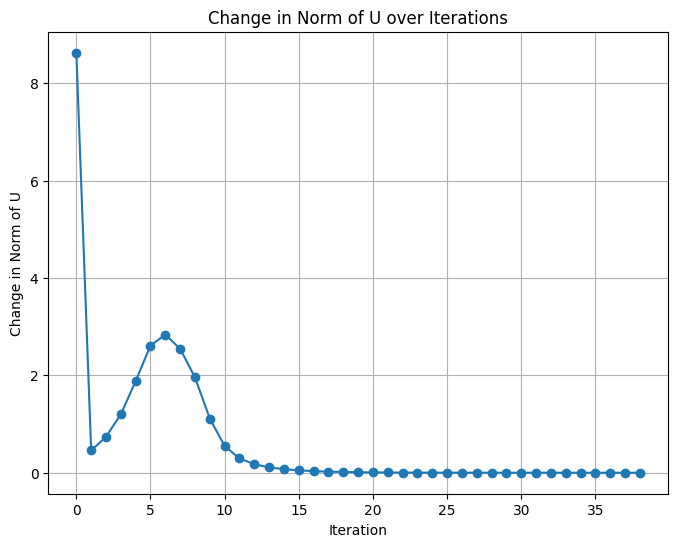

In [43]:
def fuzzyClustering(X, m1, m2, nclusters, maxiter = 50, tol = 10**(-5)):
    #TODO fill in the code
    # Step 1: Initialize the membership matrix U
    N, M = X.shape
    U = initMu(N, nclusters)
    
    # Step 2: Track changes in U to monitor convergence
    norm_changes = []
    
    for iteration in range(maxiter):
        # Step 3: Compute cluster centers based on current U
        centers = calculateCenters(X, U, m1)
        
        # Step 4: Update the membership matrix U
        U_new = updateMu(X, centers, m2)
        
        # Step 5: Compute the norm of the difference between U and U_new
        norm = np.linalg.norm(U_new - U)
        norm_changes.append(norm)
        
        # Step 6: Check for convergence
        if norm < tol:
            print(f"Converged after {iteration + 1} iterations.")
            break
        
        # Update U for the next iteration
        U = U_new
    
    # Step 7: Plot the change in norm over iterations
    plt.figure(figsize=(8, 6))
    plt.plot(norm_changes, marker='o')
    plt.title('Change in Norm of U over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Change in Norm of U')
    plt.grid(True)
    plt.show()
    
    # Return the final membership matrix U and the cluster centers
    return U, centers
#Test the function
m1 = 2
m2 = 2
nclusters = 3
U, centers = fuzzyClustering(X, m1, m2, nclusters)


**Q6.** Run the fuzzyClasssification algorithm with different hyperparameters $m_1, m_2, \textrm{nclusters}$, note the plot of $U$-norm difference against the number of iterations. <font color='blue'>What can you say about it?</font>

Now lets use the fuzzy membership to find some crisp cluster labelling $\textrm{yfuzzy}$ to for each data point. For a given datapoint you'll assign the cluster labelling by looking at which cluster assigns the largest membership value. numpy.argmax function would be useful in this case. Again avoid for loops. 

Running fuzzyClustering with m1=2, m2=2, nclusters=3
Converged after 46 iterations.


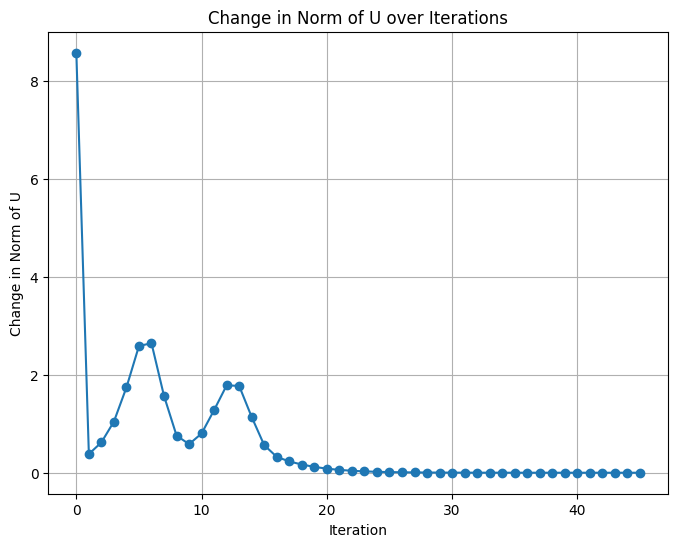

Crisp cluster labels for run 1:
[2 0 0 0 2 2 0 2 1 0 2 0 0 2 0 0 0 0 1 0 1 0 2 0 0 0 2 0 1 0 0 0 2 1 2 1 0
 0 2 1 1 0 2 0 0 0 1 0 0 0 2 0 0 0 1 0 1 1 0 2 1 0 0 1 0 2 0 1 0 0 2 1 1 0
 1 0 0 2 1 0 2 1 2 0 1 0 0 2 0 2 0 1 0 0 0 1 1 2 1 0 1 0 0 0 1 2 1 0 0 0 0
 1 0 1 1 0 0 1 0 2 1 0 1 0 1 1 0 2 1 0 1 0 0 1 0 1 0 0 1 0 1 2 0 0 1 0 2 1
 0 1 0 1 1 2 0 2 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 2 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 2 1 2 0 0 0 0 0 0 2 2 1 0 2 2 0 1 2 0 0 2 0 2 0 1
 2 0 0 0 2 0 1 0 2 2 0 0 2 2 2 0 2 0 2 0 1 0 2 2 0 0 2 2 2 0 2 0 2 0 1 0 2
 0 0 0 0 2 0 1 0 2 0 0 0 2 2 0 0 0 2 2 2 0 0 0 0 0 0 2 0 1 0 2 0 0 0 2 2 1
 0 1 1 0 1 1 1 0 0 1 0 1 1 1 1 0 2 0 1 1 0 1 1 1 0 1 0 2 2 0 1 1 0 1 2 1 0
 2 0 2 1 2 1 0 0 1 1 0 2 1 0 1 1 2 1 0 0 1 0 2 1 2 1 0 0 1 1 0 2 1 0 1 1 2
 1 0 0 0 1 1 1 0 1 2 0 1 1 0 0 2 1 2 2 1 0 1 1 2 1 1 0 2 1 0 1 1 2 0 1 2 1
 0 2 2 1 1 1 1 0 2 2 2 1 0 1 0 1 1 0 1 1 0 2 0 2 0 1 1 1 2 2 2 1 0 2

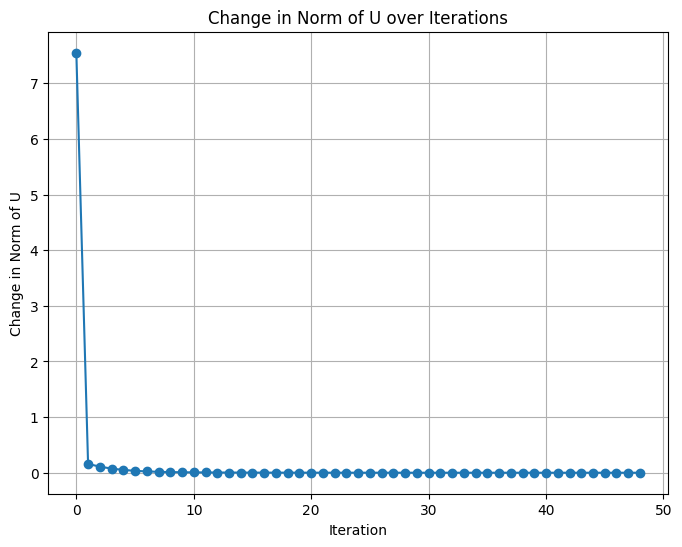

Crisp cluster labels for run 2:
[3 3 3 3 3 2 3 2 2 3 2 3 3 2 3 3 3 3 2 3 3 3 2 3 3 3 2 3 3 3 3 3 2 2 3 3 3
 3 3 2 2 3 2 3 3 3 2 3 3 3 2 3 3 3 2 3 2 3 3 3 2 3 3 3 3 2 3 3 3 3 3 2 3 3
 2 3 3 3 2 3 2 3 3 3 2 3 3 2 3 2 3 3 3 3 3 2 3 2 2 3 3 3 3 3 2 2 3 3 3 3 3
 2 3 2 3 3 3 2 3 2 3 3 2 3 2 3 3 2 2 3 2 3 3 3 3 2 3 3 2 3 2 2 3 3 2 3 2 3
 3 2 3 2 3 3 3 2 3 2 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 3 3 3 3 3
 3 3 3 2 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 2 2 3 3 2 3 3 2 2 3 3 2 3 2 3 2
 2 3 3 3 2 3 3 3 2 2 3 3 2 2 2 3 2 3 3 3 3 3 2 2 3 3 2 2 2 3 2 3 3 3 3 3 2
 3 3 3 3 3 3 3 3 2 3 3 3 2 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 2 3 2
 3 3 2 3 2 2 2 3 3 2 3 2 2 3 2 3 2 3 2 2 3 3 2 2 3 2 3 2 2 3 3 2 3 2 2 2 3
 2 3 2 2 2 2 3 3 3 2 3 2 2 3 2 2 2 2 3 3 2 3 2 2 2 2 3 3 3 2 3 2 2 3 2 2 2
 2 3 3 3 3 2 2 3 2 2 3 3 2 3 3 2 2 2 2 2 3 2 2 2 3 2 3 2 2 3 2 3 2 3 2 3 3
 3 2 2 2 2 2 2 3 2 2 2 2 3 3 3 2 2 3 3 2 3 2 3 2 3 2 2 2 2 2 2 2 3 2

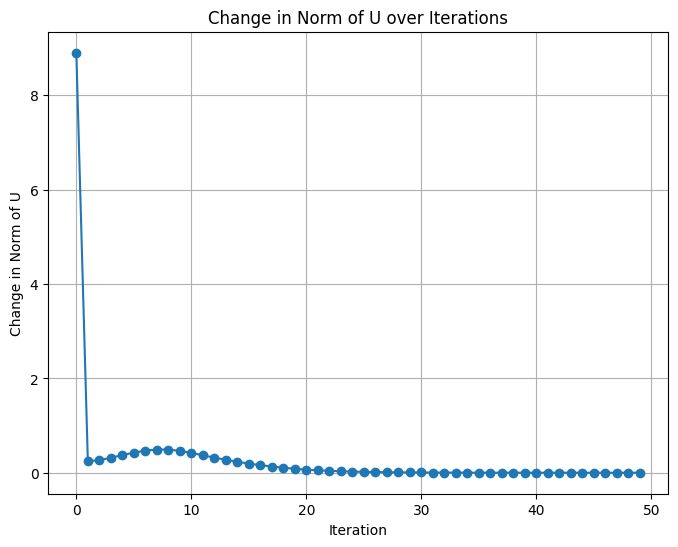

Crisp cluster labels for run 3:
[1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 0 1 1 1
 1 1 0 0 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1
 0 1 1 1 0 1 0 1 1 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1
 0 1 0 1 1 1 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 1 1 1
 1 0 1 0 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 0 1 1 1 0
 1 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0
 1 1 0 1 0 0 0 1 1 0 1 0 0 1 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 1 0 1 0 1 0 1
 0 1 0 0 0 0 1 1 1 0 1 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1 0 1 0 0 1 0 0 0
 0 1 1 1 1 0 0 1 0 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 1 0 1 1
 1 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0

In [44]:
#TODO fill in the code
def getCrispLabels(U):
    # Find the index of the maximum membership value along the columns
    # This index corresponds to the cluster assignment for each data point
    yfuzzy = np.argmax(U, axis=1)
    return yfuzzy
# Define the parameters you want to experiment with
parameters = [
    {'m1': 2, 'm2': 2, 'nclusters': 3},
    {'m1': 1.5, 'm2': 2.5, 'nclusters': 4},
    {'m1': 3, 'm2': 3, 'nclusters': 2},
]

# Loop through each set of parameters
for i, param in enumerate(parameters):
    print(f"Running fuzzyClustering with m1={param['m1']}, m2={param['m2']}, nclusters={param['nclusters']}")

    # Run fuzzy clustering with the current set of parameters
    U_final, centers_final = fuzzyClustering(X, m1=param['m1'], m2=param['m2'], nclusters=param['nclusters'])
    
    # Get the crisp cluster labels
    yfuzzy = getCrispLabels(U_final)
    
    # Print the results
    print(f"Crisp cluster labels for run {i+1}:")
    print(yfuzzy)
    print()  # Add a new line for better readability between different runs


**Q7.** The Silhoutte score is a measure of how well the clustering has been done, the closer the score to $1.0$ the better the clustering. Refer to sklearn.metrics.silhouette_score. Determine the best choice of hyperparameters $m_1, m_2, \textrm{nclusters}$ through a grid search based on the silhoutte score as the evaluation metric. <font color='blue'>Report the best combination of hyperparameters.</font> For the grid search try $m_1 = 1.0, 1.2, \cdots, 3.0$, $m_2 = 1.2, 1.4, \cdots, 3.0$, $\textrm{nclusters} = 2, 3, \cdots, 15$.

In [56]:
def fuzzyClustering(X, m1, m2, nclusters, maxiter = 50, tol = 10**(-5)):
    #TODO fill in the code
    # Step 1: Initialize the membership matrix U
    N, M = X.shape
    U = initMu(N, nclusters)
    
    # Step 2: Track changes in U to monitor convergence
    norm_changes = []
    
    for iteration in range(maxiter):
        # Step 3: Compute cluster centers based on current U
        centers = calculateCenters(X, U, m1)
        
        # Step 4: Update the membership matrix U
        U_new = updateMu(X, centers, m2)
        
        # Step 5: Compute the norm of the difference between U and U_new
        norm = np.linalg.norm(U_new - U)
        norm_changes.append(norm)
        
        # Step 6: Check for convergence
        if norm < tol:
            print(f"Converged after {iteration + 1} iterations.")
            break
        
        # Update U for the next iteration
        U = U_new
    
    # Step 7: Plot the change in norm over iterations
    # plt.figure(figsize=(8, 6))
    # plt.plot(norm_changes, marker='o')
    # plt.title('Change in Norm of U over Iterations')
    # plt.xlabel('Iteration')
    # plt.ylabel('Change in Norm of U')
    # plt.grid(True)
    # plt.show()
    
    # Return the final membership matrix U and the cluster centers
    return U, centers

In [57]:
#TODO fill in the code
from itertools import product
def gridSearchSilhouette(X, m1_values, m2_values, nclusters_values):
    best_score = -1
    best_params = None
    
    for m1 in m1_values:
        for m2 in m2_values:
            for nclusters in nclusters_values:
                # Run the fuzzy clustering algorithm
                U, centers = fuzzyClustering(X, m1, m2, nclusters)
                # Get crisp cluster labels
                yfuzzy = getCrispLabels(U)
                
                # Calculate the silhouette score
                score = silhouette_score(X, yfuzzy)
                
                # Check if this is the best score so far
                if score > best_score:
                    best_score = score
                    best_params = (m1, m2, nclusters)
                
                print(f"m1={m1}, m2={m2}, nclusters={nclusters}, score={score}")
    
    return best_params, best_score

# Define the grid search parameters
m1_values = np.arange(1.0, 3.2, 0.2)
m2_values = np.arange(1.2, 3.2, 0.2)
nclusters_values = np.arange(2, 16, 1)

# Perform grid search
best_params, best_score = gridSearchSilhouette(X, m1_values, m2_values, nclusters_values)

# Report the best combination of hyperparameters
print(f"Best Hyperparameters: m1 = {best_params[0]}, m2 = {best_params[1]}, nclusters = {best_params[2]}")
print(f"Best Silhouette Score: {best_score}")



Converged after 36 iterations.
m1=1.0, m2=1.2, nclusters=2, score=0.2507022700527657
m1=1.0, m2=1.2, nclusters=3, score=0.30013869468616594
m1=1.0, m2=1.2, nclusters=4, score=0.30484511505608053
m1=1.0, m2=1.2, nclusters=5, score=0.3680930815323226
m1=1.0, m2=1.2, nclusters=6, score=0.25274292659959485
Converged after 35 iterations.
m1=1.0, m2=1.2, nclusters=7, score=0.3114712579807909
Converged after 44 iterations.
m1=1.0, m2=1.2, nclusters=8, score=0.35815404251686944
m1=1.0, m2=1.2, nclusters=9, score=0.3984307381484141
Converged after 38 iterations.
m1=1.0, m2=1.2, nclusters=10, score=0.4531774869693209
m1=1.0, m2=1.2, nclusters=11, score=0.5012472818750628
m1=1.0, m2=1.2, nclusters=12, score=0.4474570292733381
m1=1.0, m2=1.2, nclusters=13, score=0.5211933927465798
m1=1.0, m2=1.2, nclusters=14, score=0.5504858451528402
Converged after 38 iterations.
m1=1.0, m2=1.2, nclusters=15, score=0.585513631689677
Converged after 49 iterations.
m1=1.0, m2=1.4, nclusters=2, score=0.249278367752

KeyboardInterrupt: 

**Q8.** For the best combination of hyperparameters run the following visualization function with different values for $0 \leq f_1 < f_2 < \textrm{nclusters}$. <font color='blue'>What do you see? Explain the purpose of the code and what you would expect through this?</font>

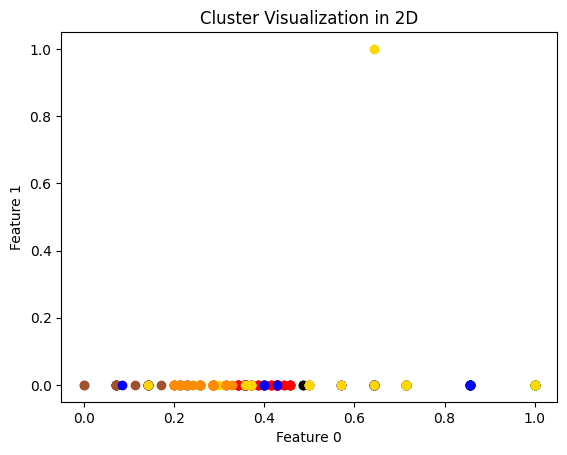

In [60]:
best_params = (1.4, 1.4, 15)
def visualizeClusters2D(X, yfuzzy, f1, f2):
    # Define a list of colors to use for different clusters
    colorlist = ['black', 'gray', 'red', 'sienna', 'green', 'blue', 'gold', 'darkorange', 
                 'olive', 'lavender', 'salmon', 'teal', 'pink', 'magenta', 'tan', 'wheat']

    # Iterate through the first 8 clusters (adjust this range based on the actual number of clusters)
    for i in range(8):  
        # Plot the data points belonging to the i-th cluster using the corresponding color
        plt.scatter(X[yfuzzy == i, f1], X[yfuzzy == i, f2], color=colorlist[i])

    # Label the x-axis with the chosen feature
    plt.xlabel(f"Feature {f1}")
    
    # Label the y-axis with the chosen feature
    plt.ylabel(f"Feature {f2}")
    
    # Set the title of the plot
    plt.title("Cluster Visualization in 2D")
    
    # Display the plot
    plt.show()

# Run the fuzzy clustering algorithm using the best hyperparameters
U_best, centers_best = fuzzyClustering(X, best_params[0], best_params[1], best_params[2])

# Convert fuzzy membership values to crisp cluster labels
yfuzzy_best = getCrispLabels(U_best)

# Visualize the clusters using the first two features (f1=0 and f2=1)
visualizeClusters2D(X, yfuzzy_best, f1=0, f2=1)


In [ ]:
#TODO fill in the code

**Q9.** Load (to a pandas dataframe) the actual dataset (SMData.csv) from which the previous dataset was cleaned out. Match each entry in this dataset with the labels you found out through clustering using the best combination of hyperparameters. Go through a few of those clustered entries and notice any patterns (or common sentiment) in the text (the "Text" column of this dataset) of each entry within clusters vs outside the clusters. The label of the $i$th entry in the dataset $= \textrm{yfuzzy}[i]$. <font color='blue'>Explain any observations. Based on your observations, is the clustering successful?</font>

In [61]:
#TODO fill in the 
import pandas as pd

# Load the actual dataset
actual_data = pd.read_csv('SMData.csv')

# Display the first few rows of the dataset to understand its structure
print(actual_data.head())

# Assuming yfuzzy_best contains the labels from the best clustering
actual_data['Cluster_Label'] = yfuzzy_best

# Display the first few rows to check the labels assignment
print(actual_data.head())

# Group the data by clusters and review some entries in each cluster
for cluster in actual_data['Cluster_Label'].unique():
    print(f"\nCluster {cluster} Entries:")
    print(actual_data[actual_data['Cluster_Label'] == cluster][['Text']].head(5))  # Display first 5 entries

   Unnamed: 0.1  Unnamed: 0  \
0             0           0   
1             1           1   
2             2           2   
3             3           3   
4             4           4   

                                                Text    Sentiment  \
0   Enjoying a beautiful day at the park!        ...   Positive     
1   Traffic was terrible this morning.           ...   Negative     
2   Just finished an amazing workout! 💪          ...   Positive     
3   Excited about the upcoming weekend getaway!  ...   Positive     
4   Trying out a new recipe for dinner tonight.  ...   Neutral      

             Timestamp            User     Platform  \
0  2023-01-15 12:30:00   User123          Twitter     
1  2023-01-15 08:45:00   CommuterX        Twitter     
2  2023-01-15 15:45:00   FitnessFan      Instagram    
3  2023-01-15 18:20:00   AdventureX       Facebook    
4  2023-01-15 19:55:00   ChefCook        Instagram    

                                     Hashtags  Retweets  Likes     